# Blue book for Bulldozers
Linear Regression contest - prediction of prices for heavy equipment auctions (Blue book for Bulldozers)

## Table of contents
* [1 Prior information](#prior)
    * [1.1 Link to the data](#link)
    * [1.2 Background information on pricing](#background)
    * [1.3 Details of the dataset provided](#details)
* [2 Exploratory Data Analysis (EDA)](#eda)
    * [2.1 Import code + PATH](#import)
    * [2.2 Seeing the data](#seeing)
        * [2.2.1 Tail and describe](#tail)
        * [2.2.2 Data sparsity](#sparsity)
        * [2.2.3 Data distribution and probability plot](#distprob-1)
        * [2.2.4 First processing](#firstproc)
            * [2.2.4.1 Dates and cetegorical values](#datescat)
        * [2.2.5 Feature analysis](#fanalysis)
            * [2.2.5.1 Numerical variables](#nvariables)
            * [2.2.5.2 Categorical variables](#cvariables)
* [3 Data processing/Feature engineering](#processing/feature)
    * [3.1 Processing the data](#processing)
        * [3.1.1 Solving skewness with log-transformation (normalization)](#distprob-2)
    * [3.2 Feature Engineering](#fengineering)
    * [3.3 Filling missing values](#filling)
    * [3.4 Dropping features or outliers](#dropping)
    
    

## 1. Prior information <a name="prior"></a>

### 1.1 Link to the data <a name="link"></a>
This kaggle's contest data is available in [here (link)](https://www.kaggle.com/c/bluebook-for-bulldozers/data).

### 1.2 Background information on pricing <a name="background"></a>
A big part of the sales process is assessing the correct value of a product or an asset. A price too high, or too low, can affect sales and profit margins which can ruin businesses if not taken into account. Moreover, predicting prices based on key features is possible when there's sales history and can help the automation of pricing.

![Deciding what's worth](http://finh.com/wp-content/uploads/2013/05/Why-Valuation-is-Important-to-Family-Businesses.jpg)

This can be used on: housing (real state), stock markets, merge and aquisition (M&A) and valuation of products. The present competition is meant to assess the valuation of heavy equipment features in order to predict prices for auctions, enabling faster and more accurate decision of how much a clients fleet is worth.

### 1.3 Details of the dataset provided <a name="details"></a>
Kaggle provides info about some of the fields of our dataset; on the [Kaggle Data info](https://www.kaggle.com/c/bluebook-for-bulldozers/data) page they say the following:

For this competition, you are predicting the sale price of bulldozers sold at auctions. The data for this competition is split into three parts:

- **Train.csv** is the training set, which contains data through the end of 2011.
- **Valid.csv** is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
- **Test.csv** is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

The key fields are in train.csv are:

- SalesID: the uniue identifier of the sale
- MachineID: the unique identifier of a machine.  A machine can be sold multiple times
- saleprice: what the machine sold for at auction (only provided in train.csv)
- saledate: the date of the sale

## 2. Exploratory Data Analysis (EDA) <a name="EDA"></a>

### 2.1 Import code + PATH <a name="imports"></a>
The code below uses Fast.AI's library, which is indicated in the ML1 course. The import list is going to increase through time and it's self-explanatory.

In [18]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

!pip install fastai
from os import path

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
from fastai.imports import *
from fastai.structured import *

from IPython.display import display

from sklearn import model_selection
from scipy.stats import norm
from scipy import stats

warnings.filterwarnings('ignore') # Ignore all warnings, can be set to 'once' also
sns.set_style('darkgrid') # The type of sns plot that I usually use

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
torch-0.3.0.post4-{platform}-linux_x86_64.whl is not a valid wheel filename.


This part was a little bit difficult due to incompatibilities and missing modules. So the first thing was to put [fastai folder](https://github.com/fastai/fastai) in a place I could always append and import. Then I had to use [this link](https://medium.com/@GuruAtWork/fast-ai-lesson-1-7fc38e978d37) to finish installing required libraries and packages. 

The PATH variable is going to be the data location, to be used on visualization/cleaning/training of the model. The files inside the PATH are listed below.

In [19]:
!pip install kaggle

from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

filename = "~/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

# !kaggle competitions list
#!kaggle competitions files -c bluebook-for-bulldozers

!kaggle competitions download  -c bluebook-for-bulldozers -p /content/kaggle

import pandas as pd
df_train_raw = pd.read_csv('/content/kaggle/Train.zip', compression='zip', header=0, sep=',', quotechar='"')

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Download 100%.
Train.7z: Skipping, found more recently modified local copy (use --force to force download)
Train.zip: Skipping, found more recently modified local copy (use --force to force download)
Valid.7z: Skipping, found more recently modified local copy (use --force to force download)
Valid.csv: Skipping, found more recently modified local copy (use --force to force download)
Valid.zip: Skipping, found more recently modified local copy (use --force to force download)
Data%20Dictionary.xlsx: Skipping, found more recently modified local copy (use --force to force download)
median_benchmark.csv: Skipping, found more recently modified local copy (use --force to force download)
Machine_Appendix.csv: Skipping, found more recently modified local copy (use --force to force download)
ValidSolution.csv: Skipping, found more recently modified local copy (use --force to force download)
TrainAndValid.7z: Skipping, found more recently

### 2.2 Seeing the data <a name="seeing"></a>
We can start by seeing the features and a piece of the data, with head/tail and describe. Then we should see how the dependent variable is distributed.

#### 2.2.1 Tail and describe <a name="tail"></a>
The tail:

In [20]:
df_train_raw.tail().T

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,11/2/2011 0:00,11/2/2011 0:00,11/2/2011 0:00,10/25/2011 0:00,10/25/2011 0:00


In [21]:
df_train_raw.describe(include = "all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
SalesID,401125,NaN,NaN,NaN,1.91971e+06,909021,1.13925e+06,1.41837e+06,1.63942e+06,2.24271e+06,6.33334e+06
SalePrice,401125,NaN,NaN,NaN,31099.7,23036.9,4750,14500,24000,40000,142000
MachineID,401125,NaN,NaN,NaN,1.2179e+06,440992,0,1.0887e+06,1.27949e+06,1.46807e+06,2.48633e+06
ModelID,401125,NaN,NaN,NaN,6889.7,6221.78,28,3259,4604,8724,37198
datasource,401125,NaN,NaN,NaN,134.666,8.96224,121,132,132,136,172
auctioneerID,380989,NaN,NaN,NaN,6.55604,16.9768,0,1,2,4,99
YearMade,401125,NaN,NaN,NaN,1899.16,291.797,1000,1985,1995,2000,2013
MachineHoursCurrentMeter,142765,NaN,NaN,NaN,3457.96,27590.3,0,0,0,3025,2.4833e+06
UsageBand,69639,3,Medium,33985,NaN,NaN,NaN,NaN,NaN,NaN,NaN
saledate,401125,3919,2/16/2009 0:00,1932,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df_train_raw.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

The data is composed of a lot of NumPy's NaN values, which is expected given the different types of machinery and it's accessories/informations.

#### 2.2.2 Data sparsity <a name="sparsity"></a>
Sometimes we have completely empty columns that, combined with correlations and feature importance, can be dropped and result in better model accuracy. Let's see the heatmap below to understand how sparse is the data.

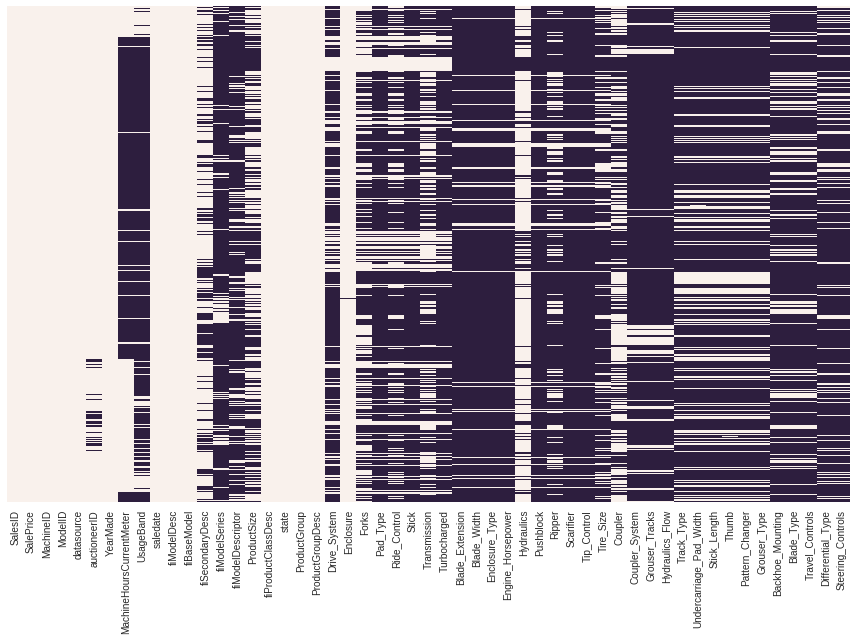

In [23]:
f1 = plt.figure(figsize=(12, 9))
ax1 = sns.heatmap(df_train_raw.isnull(), cbar=False, yticklabels=False)
plt.tight_layout()

For now, the columns which are emptier can represent accessories, which are correlated to SalePrice, so we are leaving it as is. The missing rows on each column should be filled before fitting a model and we can do this with 'proc_df' (that splits the dependent variable into a separate variable from the dataframe and fillna).

#### 2.2.3 Data distribution and probability plot <a name="distprob-1"></a>
If the data 

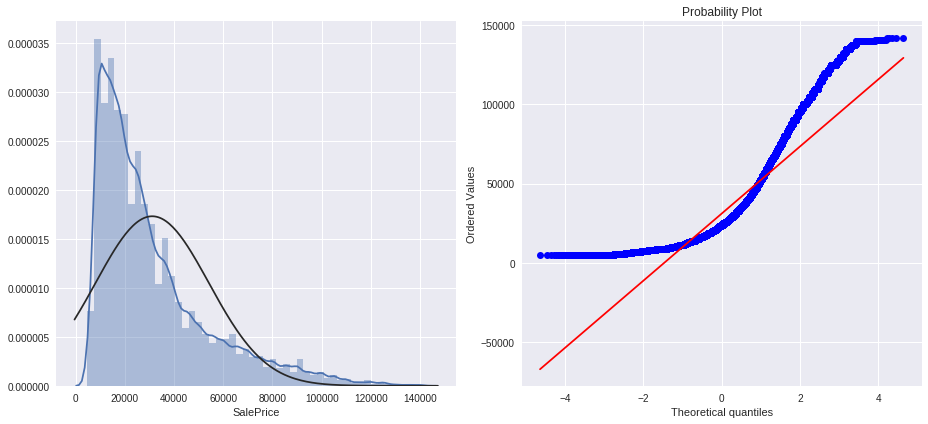

In [24]:
f2 = plt.figure(figsize = (13, 6))
plt.subplot(1, 2, 1)
ax1 = sns.distplot(df_train_raw['SalePrice'], fit=norm)
plt.subplot(1, 2, 2)
ax2 = stats.probplot(df_train_raw['SalePrice'], plot=plt)
plt.tight_layout()

From the distplot, we can visualize:
- Positive skewness (long tail to the right); 
- Positive kurtosis (tailedness);

Their values are:

In [25]:
print("Skewness: %f" % df_train_raw['SalePrice'].skew())
print("Kurtosis: %f" % df_train_raw['SalePrice'].kurt())

Skewness: 1.525133
Kurtosis: 2.197890


We were right about skewness but wrong on kurtosis, that is less than 3 and this means that it has a smaller ammount of outliers than the normal distribution, so we don't need to worry about outliers. On the other hand, positive skewness can be treated by applying log to the values (which is already expected by the problem, given the metrics is RMSLE - Root Mean Squared Logarithmic Error) in order to achieve 'homoscedasticity' and avoid different error across the data. We can evaluate again the probability plot to see how the fit to the normal distribution, on a further section. (go to [3.1.2](#distplot-2))

#### 2.2.4 First processing (dates and categorical values) <a name="firstproc"></a>

##### 2.2.4.1 Dates and categorical values <a name="datescat"></a>
According to fastai's lesson, numerical dates should always be processed using the code below, so the model can identify cyclical/trend behaviors. Also, in machine learning there's usually the need to convert strings in pandas categories, so it can use it for prediction.

In [0]:
add_datepart(df_train_raw, 'saledate')

train_cats(df_train_raw)

#### 2.2.5 Feature analysis <a name="fanalysis"></a>
One of the main purposes of EDA is to look at the data before assuming anything about it. Often there are two types of assumptions that can affect the validity of analysis: technical and business. While validating these technical and business assumptions, the data scientist will be systematically assessing the contents of each data field and its interactions with other variables, especially the key metric representing behavior that the business wants to understand or predict (e.g. user lifetime, spend). Humans are natural pattern recognizers. By exhaustively visualizing the data in different ways and positioning those visualizations strategically together, data scientists can take advantage of their pattern recognition skills to identify potential causes for behavior, identify potentially problematic or spurious data points, and develop hypotheses to test that will inform their analysis and model development strategy. (source: [KDNuggets](https://www.kdnuggets.com/2017/04/value-exploratory-data-analysis.html))

So, let's begin by seeing which columns represent numerical values and which represent categorical values.

In [27]:
num_cols = df_train_raw.select_dtypes(include = [np.number]).columns

listnum = sorted(num_cols.values.tolist())
listcat = sorted(list(set(df_train_raw) - set(num_cols)))

print ("List of numerical features:")
print (listnum)
print ("\n")
print ("List of categorical features:")
print (listcat)

List of numerical features:
['MachineHoursCurrentMeter', 'MachineID', 'ModelID', 'SalePrice', 'SalesID', 'YearMade', 'auctioneerID', 'datasource', 'saleDay', 'saleDayofweek', 'saleDayofyear', 'saleElapsed', 'saleMonth', 'saleWeek', 'saleYear']


List of categorical features:
['Backhoe_Mounting', 'Blade_Extension', 'Blade_Type', 'Blade_Width', 'Coupler', 'Coupler_System', 'Differential_Type', 'Drive_System', 'Enclosure', 'Enclosure_Type', 'Engine_Horsepower', 'Forks', 'Grouser_Tracks', 'Grouser_Type', 'Hydraulics', 'Hydraulics_Flow', 'Pad_Type', 'Pattern_Changer', 'ProductGroup', 'ProductGroupDesc', 'ProductSize', 'Pushblock', 'Ride_Control', 'Ripper', 'Scarifier', 'Steering_Controls', 'Stick', 'Stick_Length', 'Thumb', 'Tip_Control', 'Tire_Size', 'Track_Type', 'Transmission', 'Travel_Controls', 'Turbocharged', 'Undercarriage_Pad_Width', 'UsageBand', 'fiBaseModel', 'fiModelDesc', 'fiModelDescriptor', 'fiModelSeries', 'fiProductClassDesc', 'fiSecondaryDesc', 'saleIs_month_end', 'saleIs_mo

##### 2.2.5.1 Numerical variables <a name="nvariables"></a>
To have a general look in our numerical variables, we can easily understand how they correlate with each other (and our target), using the correlation matrix. It will guide our exploration and make the process more assertive.

###### Correlation Matrix <a name="corrmat"></a>
We can go deeper on studying the numerical data by seeing the correlation between all variable and understanding which are more suited for further exploration.

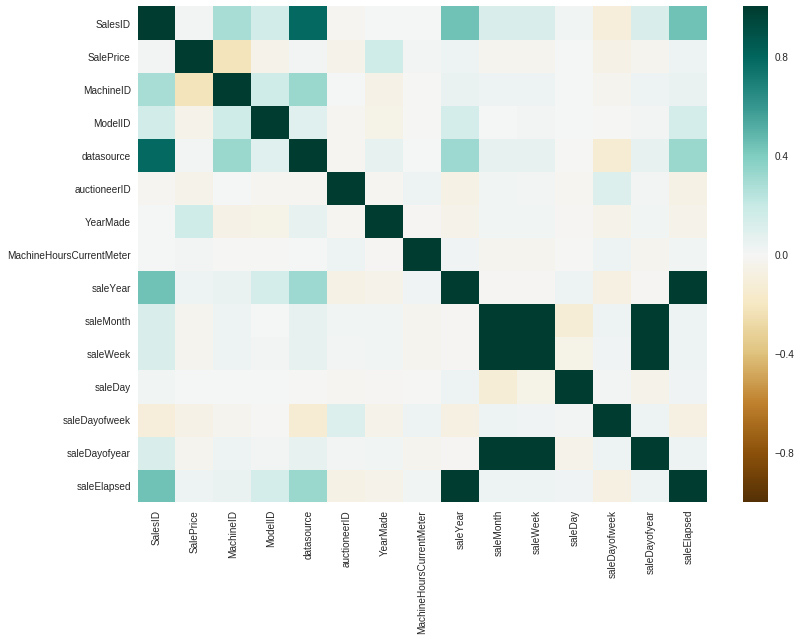

In [28]:
corrmat = df_train_raw.select_dtypes(include=[np.number]).corr() # only numerical values

f3 = plt.figure(figsize = (12, 9))
ax1 = sns.heatmap(corrmat, cmap="BrBG")
plt.tight_layout()

###### Biggest correlations <a name="highcorr"></a>
With the correlation matrix, we can identify the biggest correlations with 'SalePrice'.

In [29]:
corrdict = corrmat['SalePrice'].to_dict()
del corrdict['SalePrice']
print("List the numerical features decendingly by their correlation with Sale Price:\n")
for ele in sorted(corrdict.items(), key = lambda x: -abs(x[1])):
    print("{0}: \t{1}".format(*ele))

List the numerical features decendingly by their correlation with Sale Price:

MachineID: 	-0.22485438801062493
YearMade: 	0.1564526041911871
saleDayofweek: 	-0.05682276051200205
auctioneerID: 	-0.046865367306050364
ModelID: 	-0.042124753481464085
saleYear: 	0.038483892755546624
saleElapsed: 	0.037051382583293366
saleDayofyear: 	-0.028555846653709752
saleMonth: 	-0.028498193747108335
saleWeek: 	-0.028017746016265402
datasource: 	0.015121945713969024
MachineHoursCurrentMeter: 	0.013559544213488003
SalesID: 	0.010724769219988583
saleDay: 	1.317620973253017e-05


The most correlated features to equipment princing are **MachineID**, **YearMade**, **saleDayofweek**, **auctioneerID** and **ModelID**. **saleDayofyear** seems to also have a lot of categories, so it's in. We can study their distributions and see if there're any improvements for our model.

We can also identify a big correlation between 'SalesID' and 'datasource', which we can see how they correlate on the next topic. I'm also guessing that 'ModelID' correlates with 'MachineID' in some way, let's find out.

##### Distribution of numerical variables
It's important to see how our independent variables are distributed, so we can decide what to do with them to improve our models accuracy. Let's have a look at **saleYear** and **YearMade**.

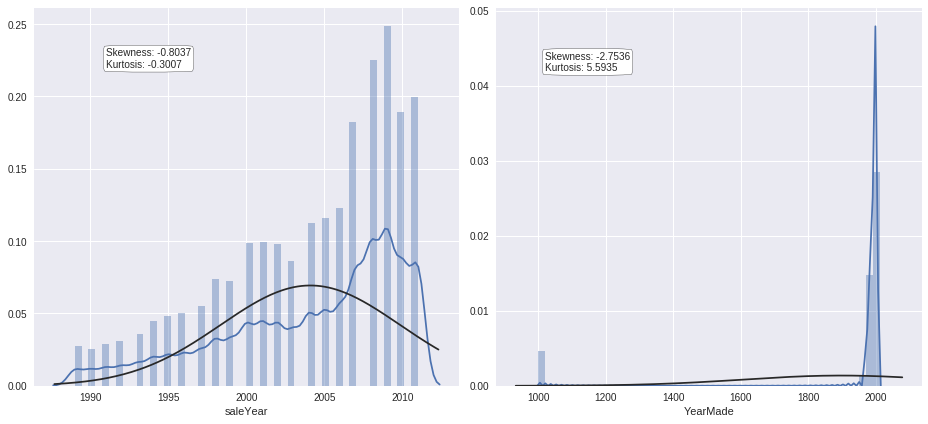

In [30]:
skew_kurt_saleYear = 'Skewness: ' + str(round(df_train_raw['saleYear'].skew(), 4)) +\
              '\n' +'Kurtosis: ' + str(round(df_train_raw['saleYear'].kurt(), 4))
skew_kurt_YearMade = 'Skewness: ' + str(round(df_train_raw['YearMade'].skew(), 4)) +\
              '\n' +'Kurtosis: ' + str(round(df_train_raw['YearMade'].kurt(), 4))

f = plt.figure(figsize = (13, 6))
plt.subplot(1, 2, 1)
ax1 = sns.distplot(df_train_raw['saleYear'], fit=norm)
ax1.annotate(skew_kurt_saleYear, xy = (1988, 0.22), xytext = (1991, 0.22), bbox = dict(boxstyle="round4", fc="w"))
plt.subplot(1, 2, 2)
ax2 = sns.distplot(df_train_raw['YearMade'], fit=norm)
ax2.annotate(skew_kurt_YearMade, xy = (1020, 0.042), xytext = (1020, 0.042), bbox = dict(boxstyle="round4", fc="w"))
plt.tight_layout()

Both are left skewed, and YearMade have a lot of machines made in 1000, but that's not possible! We'll have to handle this outliers in section [3.4](#dropping). The Kurtosis also show small tailedness for both (negative Kurtosis), which is good for modeling. Skewness if almost 0 for both, making them closer to a normal distribution.

Next we will see the distplots for **MachineID** and **saleDayofweek**.

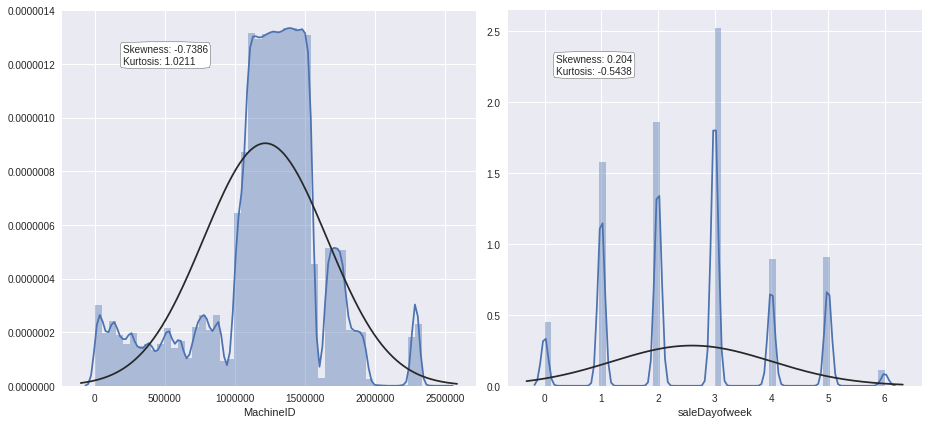

In [31]:
skew_kurt_MachineID = 'Skewness: ' + str(round(df_train_raw['MachineID'].skew(), 4)) +\
              '\n' +'Kurtosis: ' + str(round(df_train_raw['MachineID'].kurt(), 4))
skew_kurt_saleDay = 'Skewness: ' + str(round(df_train_raw['saleDayofweek'].skew(), 4)) +\
              '\n' +'Kurtosis: ' + str(round(df_train_raw['saleDayofweek'].kurt(), 4))

f = plt.figure(figsize = (13, 6))
plt.subplot(1, 2, 1)
ax1 = sns.distplot(df_train_raw['MachineID'], fit=norm)
ax1.annotate(skew_kurt_MachineID, xy = (200000, 0.0000012), xytext = (200000, 0.0000012), bbox = dict(boxstyle="round4", fc="w"))
plt.subplot(1, 2, 2)
ax2 = sns.distplot(df_train_raw['saleDayofweek'], fit=norm)
ax2.annotate(skew_kurt_saleDay, xy = (0.2, 2.2), xytext = (0.2, 2.2), bbox = dict(boxstyle="round4", fc="w"))
plt.tight_layout()

**saleDayofweek** can be treated as categorical and the data in **MachineID** presents low density, indicating a lot of different values distributed throughout it's range. We'll drop it on [3.3](#dropping).

Let's analyze the last two features: **auctioneerID** and **saleDayofyear**.

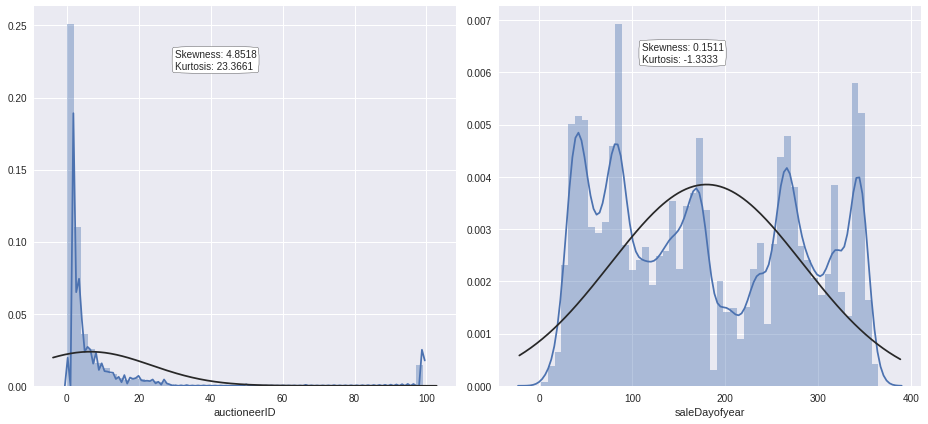

In [32]:
skew_kurt_MachineID = 'Skewness: ' + str(round(df_train_raw['auctioneerID'].skew(), 4)) +\
              '\n' +'Kurtosis: ' + str(round(df_train_raw['auctioneerID'].kurt(), 4))
skew_kurt_saleDay = 'Skewness: ' + str(round(df_train_raw['saleDayofyear'].skew(), 4)) +\
              '\n' +'Kurtosis: ' + str(round(df_train_raw['saleDayofyear'].kurt(), 4))

f = plt.figure(figsize = (13, 6))
plt.subplot(1, 2, 1)
ax1 = sns.distplot(df_train_raw['auctioneerID'].interpolate(method='linear'), fit=norm)
ax1.annotate(skew_kurt_MachineID, xy = (30, 0.22), xytext = (30, 0.22), bbox = dict(boxstyle="round4", fc="w"))
plt.subplot(1, 2, 2)
ax2 = sns.distplot(df_train_raw['saleDayofyear'], fit=norm)
ax2.annotate(skew_kurt_saleDay, xy = (110, 0.0062), xytext = (110, 0.0062), bbox = dict(boxstyle="round4", fc="w"))
plt.tight_layout()

###### Ammount of sales by year
Is Bulldozers doing well? According, to the distribution, the trend is rising sales. The last **SaleYear** is 2011. We can filter by **ProductGroupDesc** to identify when each product started to be sold.

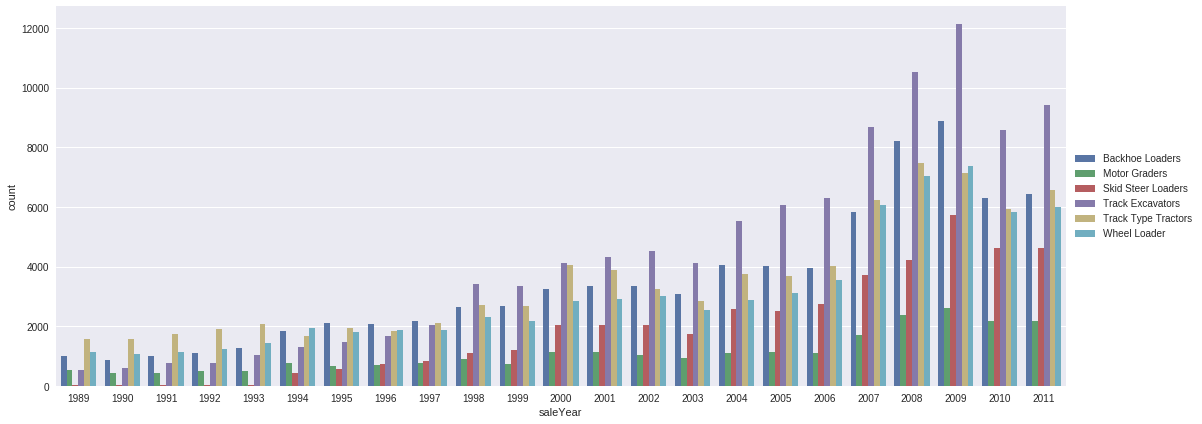

In [33]:
f = plt.figure(figsize = (15, 6))
sns.countplot('saleYear', hue = 'ProductGroupDesc', data = df_train_raw)
plt.legend(loc = 'center left', bbox_to_anchor=(1, 0.5), frameon = False)
plt.tight_layout()

From 1994 on, all machines started to be sold. This year marks the beginning of Skid Steer Loaders sales. Motor Graders in general sold less units than the other groups. We can also see that Track Excavators are growing more trendy through time.

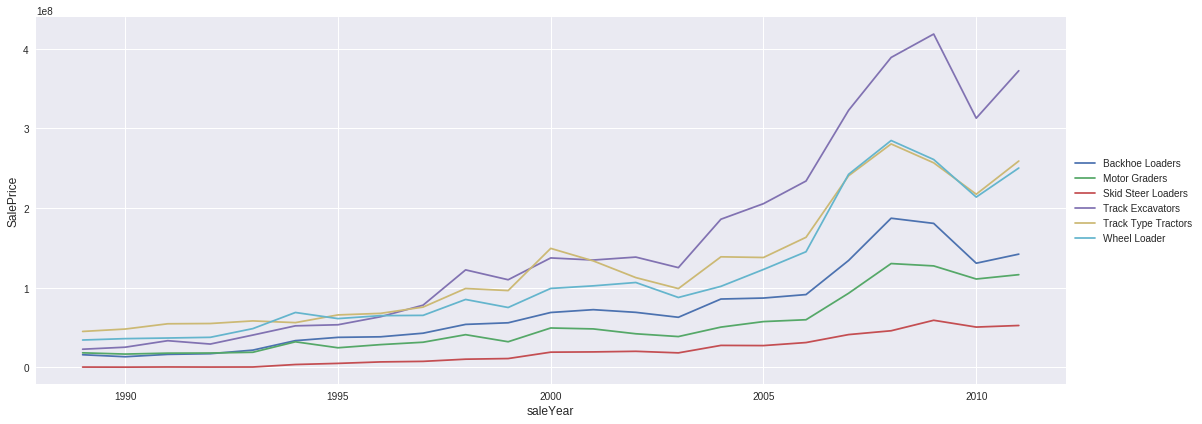

In [34]:
f, ax = plt.subplots(figsize = (15, 6))
df_train_raw.groupby(['saleYear', 'ProductGroupDesc']).sum()['SalePrice'].unstack().plot(ax = ax)
plt.ylabel('SalePrice', fontsize = 12)
plt.xlabel('saleYear', fontsize = 12)
plt.legend(loc = 'center left', bbox_to_anchor=(1, 0.5), frameon = False)
plt.tight_layout()

Seeing the ammount of units sold per year doesn't tell the whole story, the value is also key. The products that generated more revenue are Track Type Tractors, Track Excavators and Wheel Loaders . They all seem to have bigger mean prices than Backhoe Loaders, due to the ammount of units comparison, which we can find out with the graph below.

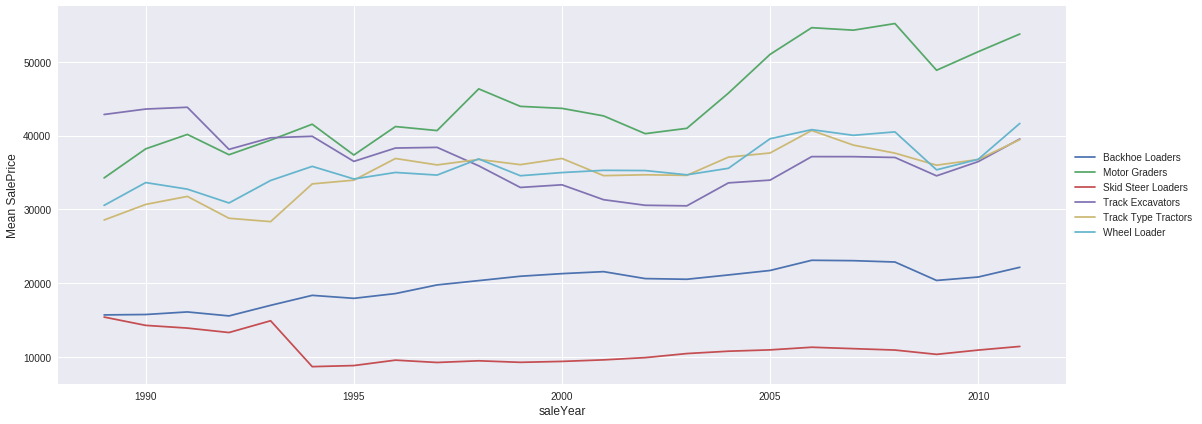

In [35]:
f, ax = plt.subplots(figsize = (15, 6))
df_train_raw.groupby(['saleYear', 'ProductGroupDesc']).mean()['SalePrice'].unstack().plot(ax = ax)
plt.ylabel('Mean SalePrice', fontsize = 12)
plt.xlabel('saleYear', fontsize = 12)
plt.legend(loc = 'center left', bbox_to_anchor=(1, 0.5), frameon = False)
plt.tight_layout()

Surprisingly, the biggest mean price belongs to Motor Graders, followed by the ones we identified.

###### Ammount of machines made by year


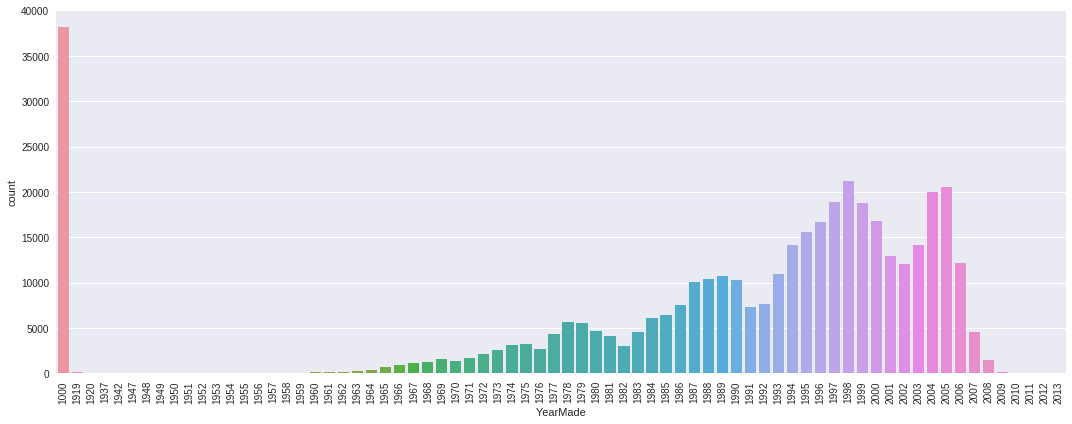

In [36]:
f = plt.figure(figsize = (15, 6))
plt.xticks(rotation='90')
ax1 = sns.countplot('YearMade', data = df_train_raw)
plt.tight_layout()

###### 'SalesID' and 'datasource' correlation
Based on the correlation matrix, these too seem highly correlated. Let's see their regplot and findout how their data correlate.

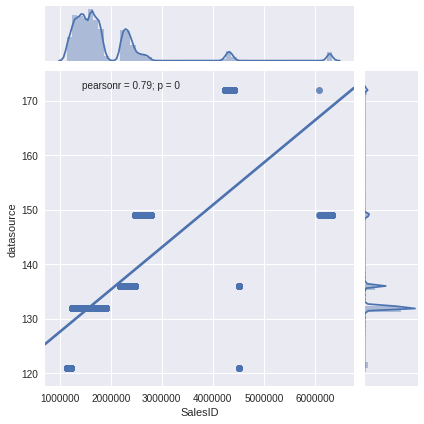

In [37]:
f4 = plt.figure()
ax1 = sns.jointplot(df_train_raw.loc[:,'SalesID'], df_train_raw.loc[:,'datasource'], kind="regg")
plt.tight_layout()

By looking at the jointplot, it's clear that 'datasource' is categorical and 'SalesID' numerical. We'll be binning 'SalesID' in [3.2.1](#binning) in order to improve our model.

##### 2.2.5.2 Categorical variables <a name="cvariables"></a>

There are lot's of categorical variables and we can choose some of them to visualize their distribution. We can have a look at which categorical variables are less empty, using the code below:

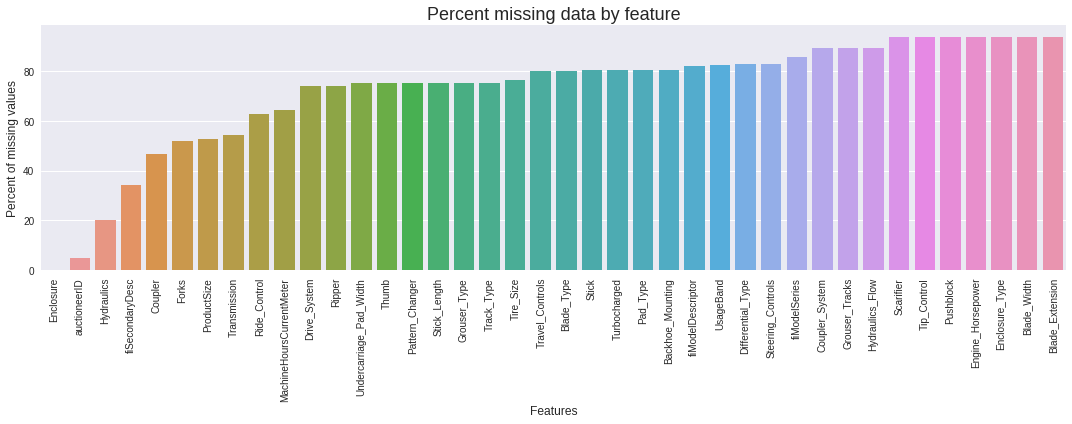

In [38]:
missing_values = df_train_raw.isnull().sum() * 100 / len(df_train_raw)
missing_values = missing_values.drop(missing_values[missing_values == 0].index).sort_values(ascending = True)
missing_df = pd.DataFrame({'Missing Ratio': missing_values})

f5 = plt.figure(figsize=(15, 6))
plt.xticks(rotation = '90')
ax1 = sns.barplot(x = missing_df.index, y = missing_df['Missing Ratio'])
plt.xlabel('Features', fontsize = 12)
plt.ylabel('Percent of missing values', fontsize = 12)
plt.title('Percent missing data by feature', fontsize = 18)
plt.tight_layout()

In [39]:
missing_df.head(8)

,Missing Ratio
Enclosure,0.081022
auctioneerID,5.019882
Hydraulics,20.082269
fiSecondaryDesc,34.201558
Coupler,46.662013
Forks,52.115425
ProductSize,52.545964
Transmission,54.320972


We can use **ProductGroupDesc**, **state**, **Hydraulics** and **Enclosure** to see the impact of those in the 'SalePrice'. **auctioneerID** actually has too many categories, so we're leaving it out. Let's boxplot!

In [40]:
f6 = plt.figure()
with sns.axes_style("darkgrid", {"xtick.bottom": True}):
    ax1 = sns.catplot(x = 'ProductGroupDesc', y = 'SalePrice', kind = "violin", data = df_train_raw, height = 3, aspect = 4)
    ax2 = sns.catplot(x = 'Hydraulics', y = 'SalePrice', kind = "violin", data = df_train_raw, height = 3, aspect = 4)
    ax2.set_xticklabels(rotation = 30, ha = "right")
    ax3 = sns.catplot(x = 'Enclosure', y = 'SalePrice', kind = "violin", data = df_train_raw, height = 3, aspect = 4)

AttributeError: ignored

From those above, it's possible to infer that:
* The different types of machines influence the price:
    * **Skid Steer Loaders** are the cheapest without overlapping with other boxes;
    * All the others boxes overlap, with **Backhoe Loaders** having the smallest medium price and **Moto Graders** the highest;
    * The distribution for **Track Excavators**, **Track Type Tractors** and **Wheel Loaders** have almost identical distributions.
* The different types of hydraulics influence the price:
    * More valves means more expensive machinery;
    * Number of functions increased the price until 2, then plateaued until 4 and decreased.
* The type of enclosure also influence the price:
    * **EROPS w AC** or **NO ROPS** are more common in more expensive machinery;
    * Machines containing **OROPS**, **EROPS**, **EROPS AC** or none have similar prices.

<Figure size 432x288 with 0 Axes>

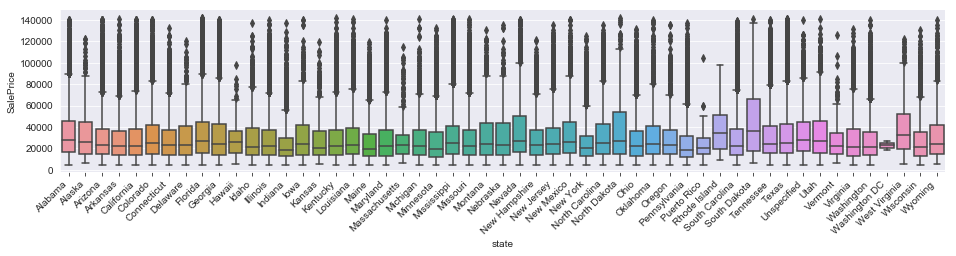

In [0]:
f7 = plt.figure()

with sns.axes_style("darkgrid", {"xtick.bottom": True}):
    ax1 = sns.catplot(x = 'state', y = 'SalePrice', kind = "box", data = df_train_raw, height = 3, aspect = 4.5)
    ax1.set_xticklabels(rotation = 45, ha = "right")

There are a lot of outliers, which will be left untreated. All boxes overlap and mean prices are more or less higher in states like Rhode Island, South Dakota and West Virginia.

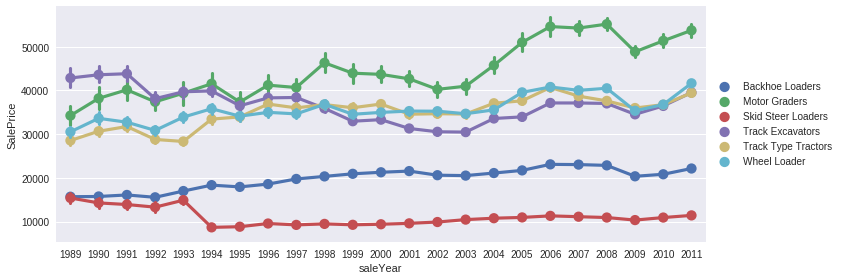

In [41]:
# If wanting just one of the graphics below, try this code:
# df_product = df_train_raw.set_index(['ProductGroupDesc'])
# sns.factorplot(data = df_product.loc['Backhoe Loaders'], x = "saleYear", y = "SalePrice", aspect=2)

f8 = plt.figure()
with sns.axes_style("darkgrid", {"xtick.bottom": True}):
    ax1 = sns.factorplot(data = df_train_raw, x = "saleYear", y = "SalePrice",\
                         hue = "ProductGroupDesc", aspect = 2.5, legend = False) 
plt.legend(loc = 'center left', bbox_to_anchor=(1, 0.5), frameon = False)
plt.tight_layout()

## 3 Data processing/Feature engineering <a name="processing/feature"></a>
### 3.1 Processing the data <a name="processing"></a>

#### 3.1.1 Solving skewness with log-transformation (normalization) <a name="distprob-2"></a>
Based on section [2.2.3](#distplot-1), skewness can complicate data analysis and modeling and it's better for us to have our dependent variable as normal as possible. Our choice to use in here (given constraints on this contest's scope) is to use log-trasformation and it'll be used on RMSLE. We could also use [Box-Cox tranformation](http://onlinestatbook.com/2/transformations/box-cox.html), which can lead to better results in some datasets. So, let's transform and have a new look at de ditribution and probability plot.

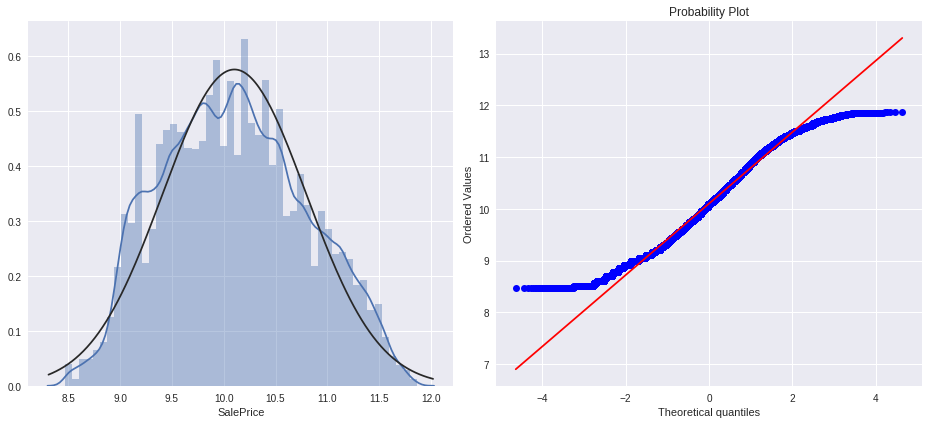

In [42]:
df_train_raw.SalePrice = np.log(df_train_raw.SalePrice)

plt.figure(figsize = (13, 6))
plt.subplot(1, 2, 1)
sns.distplot(df_train_raw['SalePrice'], fit=norm)
plt.subplot(1, 2, 2)
res = stats.probplot(df_train_raw['SalePrice'], plot=plt)
plt.tight_layout()

Now the data is more similar to the normal distribution and this will likely improve our model's ability to predict throughout the whole dataset. Let's see the new skewness and kurtosis:

In [43]:
print("Skewness: {:.4f}" .format(df_train_raw['SalePrice'].skew()))
print("Kurtosis: {:.4f}" .format(df_train_raw['SalePrice'].kurt()))

Skewness: 0.1518
Kurtosis: -0.6883


We almost got a normal distribution (skewness = 0) and our kurtosis is negative (platykurtosis, light tail with not much outliers), which are both great for modeling.

### 3.2 Feature Engineering <a name="fengineering"></a>
#### 3.2.1 Binning continuous variables
###### saleYear and quantiles
As a continuous variable, it's useful to bin in in quantiles to bring more useful information for the algorithm.

In [0]:
quantile_list = [0, .25, .5, .75, 1.]
quantile_labels = ['0-25Q', '25-50Q', '50-75Q', '75-100Q']
df_train_eng = df_train_raw
df_train_eng['saleYear_label'] = pd.qcut(df_train_eng['saleYear'], q = quantile_list, labels=quantile_labels)
pd.get_dummies(df_train_eng, prefix=['saleYear_label'], columns=['saleYear_label']);

###### SalesID and quantiles
As said before, continuous variables can be more useful when binned. Let's do that!

In [0]:
df_train_eng['SalesID_label'] = pd.qcut(df_train_eng['SalesID'], q = quantile_list, labels=quantile_labels)
pd.get_dummies(df_train_eng, prefix=['SalesID_label'], columns=['SalesID_label']);

#### 3.2.2 Hashing categorical features
###### state and hashing


In [46]:
from sklearn.feature_extraction import FeatureHasher

fh = FeatureHasher(n_features=6, input_type='string')
hashed_features = fh.fit_transform(df_train_eng['state'])
hashed_features = hashed_features.toarray()

pd.concat([df_train_eng, pd.DataFrame(hashed_features)], axis=1)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleIs_year_start,saleElapsed,saleYear_label,SalesID_label,0,1,2,3,4,5
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,...,False,1163635200,25-50Q,0-25Q,0.0,0.0,4.0,0.0,2.0,-1.0
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,...,False,1080259200,25-50Q,0-25Q,-1.0,4.0,4.0,-3.0,0.0,-2.0
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,...,False,1077753600,25-50Q,0-25Q,0.0,2.0,1.0,-1.0,0.0,-2.0
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,...,False,1305763200,75-100Q,0-25Q,0.0,0.0,1.0,-1.0,0.0,1.0
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,...,False,1248307200,50-75Q,0-25Q,0.0,2.0,1.0,-1.0,0.0,-2.0
5,1139255,10.184900,1001274,4605,121,3.0,2004,508.0,Low,310G,...,False,1229558400,50-75Q,0-25Q,-1.0,2.0,1.0,-2.0,1.0,0.0
6,1139256,9.952278,772701,1937,121,3.0,1993,11540.0,High,790ELC,...,False,1093478400,25-50Q,0-25Q,0.0,3.0,1.0,-1.0,0.0,0.0
7,1139261,10.203592,902002,3539,121,3.0,2001,4883.0,High,416D,...,False,1132185600,25-50Q,0-25Q,0.0,1.0,2.0,-3.0,0.0,0.0
8,1139272,9.975808,1036251,36003,121,3.0,2008,302.0,Low,430HAG,...,False,1251331200,50-75Q,0-25Q,0.0,0.0,1.0,-1.0,0.0,1.0
9,1139275,11.082143,1016474,3883,121,3.0,1000,20700.0,Medium,988B,...,False,1186617600,50-75Q,0-25Q,0.0,3.0,1.0,-1.0,0.0,0.0


### 3.3 Dropping <a name="dropping"></a>
#### 3.2.1 Columns
###### saleYear, SalesID, state

In [0]:
df_train = df_train_eng.drop(['saleYear', 'SalesID', 'state', 'MachineID', 'saleDayofyear', 'Grouser_Tracks'], axis = 1)

#### 3.2.2 Rows 
###### With 'YearMade' == 1000

We have dropped 38185 rows, which amounts to 9.52% of the total.


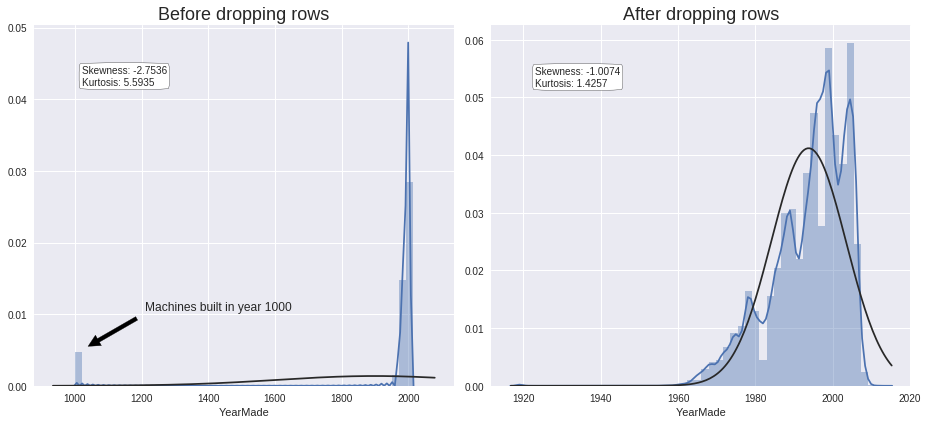

In [48]:
value = len(df_train[df_train_eng['YearMade'] == 1000].index)
percentage_total = 100 * (value/len((df_train['YearMade'].index)))
print("We have dropped {:d} rows, which amounts to {:.2f}% of the total." .format(value, percentage_total))

df_train = df_train.drop(df_train[df_train['YearMade'] == 1000].index)
skew_kurt_1 = 'Skewness: ' + str(round(df_train_eng['YearMade'].skew(), 4)) +\
              '\n' +'Kurtosis: ' + str(round(df_train_eng['YearMade'].kurt(), 4))
skew_kurt_2 = 'Skewness: ' + str(round(df_train['YearMade'].skew(), 4)) +\
              '\n' +'Kurtosis: ' + str(round(df_train['YearMade'].kurt(), 4))

plt.figure(figsize = (13, 6))
plt.subplot(1, 2, 1)
ax1 = sns.distplot(df_train_eng['YearMade'], fit=norm)
plt.title('Before dropping rows', fontsize = 18)
ax1.annotate('Machines built in year 1000', xy = (1020, 0.005), xytext = (1210, 0.0105),
             arrowprops = dict(facecolor = 'black', shrink = 0.1), fontsize = 12)
ax1.annotate(skew_kurt_1, xy = (1020, 0.042), xytext = (1020, 0.042), bbox = dict(boxstyle="round4", fc="w"))
plt.subplot(1, 2, 2)
ax2 = sns.distplot(df_train['YearMade'], fit=norm)
plt.title('After dropping rows', fontsize = 18)
ax2.annotate(skew_kurt_2, xy = (1923, 0.052), xytext = (1923, 0.052), bbox = dict(boxstyle="round4", fc="w"))
plt.tight_layout()

### 3.4 Filling missing values and splitting sets <a name="filling"></a>


In [0]:
df, y, nas = proc_df(df_train, 'SalePrice')

## 4 Modeling
### 4.1 Base models

#### 4.1.1 Random Forest

In [0]:
# Implementation of RMSE (using our log(Y), we'll have RMLSE)
def rmse(x, y): return math.sqrt(((x - y)**2).mean())

# Fast.AI's ML1 course created the function below, adapted for my needs.
def print_score(m, X_train, y_train, X_valid, y_valid):
    res = 'Training RMLSE: ' + str(rmse(m.predict(X_train), y_train)) + '\n' +\
          'Validation RMLSE: ' + str(rmse(m.predict(X_valid), y_valid)) + '\n' +\
          'Training score: ' + str(m.score(X_train, y_train)) + '\n' +\
          'Validation score: ' + str(m.score(X_valid, y_valid))
    print(res)

# split_vals returns splits in data, which can be faster than sklearn inbuilt function.
def split_vals(a, n): return a[:n].copy(), a[n:].copy()

def best_GridSearch(estimator, param_grid, X_train, y_train, X_test, y_test):
    """
    Function to optimize the fit with data. 
    
    Works with give regressors estimators (RF, XGB, GBT, SVM, etc) and param_grid, 
    which will be used to search the best model. Prints the best params, the 
    accuracy assessment and returns the best model.
    """
    regressor = model_selection.GridSearchCV(estimator = estimator, 
                                             cv = 5,
                                             param_grid = param_grid, 
                                             verbose = 2, n_jobs = -1)
    regressor.fit(X_train, y_train)
    bestmodel = regressor.best_estimator_

    # OK great, so we got back the best estimator parameters as follows:
    print ("-----------  Best Estimator Parameters  -----------")
    print (regressor.best_params_)
    print ("-----------  ACCURACY ASSESSMENT -----------")
    print_score(bestmodel, X_train, y_train, X_test, y_test)
    
    return bestmodel

# Splitting the data to better represent Kaggle's conditions
n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df) - n_valid
raw_train, raw_valid = split_vals(df_train, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

In [0]:
#from sklearn.ensemble import RandomForestRegressor

# Base model, from FAST.AI's course (marginal difference, probably due to our feature engineering)
#m_rf = RandomForestRegressor(n_estimators = 160, max_features = 0.5, n_jobs = -1, oob_score = True, random_state = 42)
#%time m_rf.fit(X_train, y_train)
#print_score(m_rf, X_train, y_train, X_valid, y_valid)

#Wall time: 3min 38s
#Training RMLSE: 0.07240376965322595
#Validation RMLSE: 0.21325558101385955
#Training score: 0.9889362304756446
#Validation score: 0.9201234688759963

In [0]:
# param_grid_rf = {'max_depth': range(2, 8, 2)
#              #'colsample_bytree': [i/100.0 for i in range(78,87)]
#              # between 0,1 : [i/10.0 for i in range(6,10)]
#              # greater than 1 : range(2,10,2)
#                }

# base_model_rf = RandomForestRegressor(n_estimators = 160, 
#                                    max_features = 0.5, 
#                                    n_jobs = -1, 
#                                    oob_score = True,
#                                    bootstrap = True,
#                                    random_state = 42)

# best_model_rf = best_GridSearch(base_model_rf, param_grid_rf, X_train, y_train, X_valid, y_valid)

#### 4.1.2 XGBoost

In [0]:
#from xgboost import XGBRegressor as xgb

#m_xgb = xgb(max_depth = 16, min_child_weight = 13, learning_rate = 0.1, seed = 42)
#%time m_xgb.fit(X_train, y_train)
#print_score(m_xgb, X_train, y_train, X_valid, y_valid)

In [61]:
from xgboost import XGBRegressor as xgb

param_grid_xgb = {'reg_alpha': [0, 0.001, 0.01, 0.1, 0.2, 0.5, 0.8, 1],
                  'reg_lambda': [0, 0.001, 0.01, 0.1, 0.5, 1, 1.2, 1.5],
                  'max_depth': [15, 16, 17],
                  'min_child_weight': [12, 13, 14]
                  # between 0,1 : [i/10.0 for i in range(6,10)]
                  # greater than 1 : range(2,10,2)
}

base_model_xgb = xgb(max_depth = 16, min_child_weight = 13, learning_rate = 0.1, seed = 42)

best_model_xgb = best_GridSearch(base_model_xgb, param_grid_xgb, X_train, y_train, X_valid, y_valid)

#-----------  Best Estimator Parameters  -----------
#{'reg_alpha': 0.15, 'reg_lambda': 1.2}
#-----------  ACCURACY ASSESSMENT -----------
#Training RMLSE: 0.1445370430871731
#Validation RMLSE: 0.21650120956626634
#Training score: 0.9559101018481306
#Validation score: 0.917673616317562

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
[CV] max_depth=15, min_child_weight=12, reg_alpha=0, reg_lambda=0 ....
[CV] max_depth=15, min_child_weight=12, reg_alpha=0, reg_lambda=0 ....


Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/pool.py", line 360, in get
    racquire()
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/pool.py", line 360, in get
    racquire()
KeyboardInterrupt
KeyboardInterrupt


KeyboardInterrupt: ignored

In [0]:
#eval_set = [(X_valid, y_valid)]

#m_xgb = xgb(n_estimators = 10000, max_depth = 16, min_child_weight = 13, learning_rate = 0.01, seed = 42)
#%time m_xgb.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = "rmse", eval_set = eval_set, verbose=True)
#print_score(m_xgb, X_train, y_train, X_valid, y_valid)

#[2765]	validation_0-rmse:0.211044

#Wall time: 3h 22min 6s
#Training RMLSE: 0.11143495569600186
#Validation RMLSE: 0.2110443048198749
#Training score: 0.9737926171231812
#Validation score: 0.9217713819147486

#### 4.1.3 SVR

In [0]:
#from sklearn.svm import SVR

#base_model_svr = SVR(kernel = 'linear', C = 0.11, epsilon = 0.011, gamma = 0.1)
#%time m_rf.fit(X_train, y_train)
#print_score(m_rf, X_train, y_train, X_valid, y_valid)

#Wall time: 5min 45s
#Training RMLSE: 0.07240376965322595
#Validation RMLSE: 0.21325558101385955
#Training score: 0.9889362304756446
#Validation score: 0.9201234688759963

In [0]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV

random_grid_svr = {'C': [0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1, 1.2, 1.5],
                  'kernel': ['linear'],
                  'degree': [2, 3, 4, 5, 10],
                  'epsilon': [0.001, 0.01, 0.02, 0.05, 0.08, 0.1, 0.2, 0.5, 0.8],
                  'gamma': [0.001, 0.01, 0.02, 0.05, 0.08, 0.1, 0.2, 0.5, 0.8]
}

m_svr = SVR()
m_svr_random = RandomizedSearchCV(estimator = m_svr, param_distributions = random_grid_svr, n_iter = 20, cv = 3, verbose = 2, random_state = 42)
m_svr_random.fit(X_train, y_train)

m_svr_random.best_params_

#### 4.1.4 AdaBoost

In [0]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
random_grid_adb = {'n_estimators': [20, 50, 100, 200, 500, 1000, 10000],
                   'loss': ['linear', 'square', 'exponential'],    
}

ada_tree = DecisionTreeRegressor(max_features = 'sqrt', splitter = 'random', max_depth = 10)
m_adb = AdaBoostRegressor(ada_tree, learning_rate = 0.01, n_jobs = -1, random_state = 42)
m_adb_random = RandomizedSearchCV(estimator = m_adb, param_distributions = random_grid_adb, n_iter = 15, cv = 3, verbose=2, random_state = 42)
m_adb_random.fit(X_train, y_train)

m_adb_random.best_params_

#### 4.1.5 ElasticNet

In [0]:
from sklearn.linear_model import ElasticNet

random_grid_en = {'alpha': [0, 0.5, 1, 2, 4, 5, 10],
                  'l1_ratio': [0, 0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 0.9, 1]    
}

m_en = ElasticNet(random_state = 42)
m_en_random = RandomizedSearchCV(estimator = m_en, param_distributions = random_grid_en, n_iter = 20, cv = 3, verbose=2, random_state = 42, n_jobs = -1)
m_en_random.fit(X_train, y_train)

m_en_random.best_params_

#### 4.1.6 Neural network (MLPRegressor)

In [0]:
from sklearn.neural_network import MLPRegressor

random_grid_mlp = {'solver': ['lbfgs', 'sgd', 'adam'],
                  'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 10],
                  'learning_rate': ['constant', 'invscaling', 'adaptive']
}

m_mlp = MLPRegressor(random_state = 42)
m_mlp_random = RandomizedSearchCV(estimator = m_mlp, param_distributions = random_grid_mlp, n_iter = 20, cv = 3, verbose=2, random_state = 42)
m_mlp_random.fit(X_train, y_train)

m_mlp_random.best_params_

#### 4.1.6 Neural network (MLPRegressor)

In [0]:
from sklearn.ensemble import IsolationForest

random_grid_if = {'n_estimators': [10, 50, 100, 200, 500, 1000, 10000],
                  'max_samples': ['auto', 500, 1000, 10000],
                  'max_features': [0.2, 0.5, 1]
}

m_if = IsolationForest(random_state = 42)
m_if_random = RandomizedSearchCV(estimator = m_if, param_distributions = random_grid_if, n_iter = 20, cv = 3, verbose=2, random_state = 42)
m_if_random.fit(X_train, y_train)

m_if_random.best_params_